In [1]:
import math
import matplotlib.pyplot as plt
import keras
from datetime import time
from datetime import datetime
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping


Using TensorFlow backend.


In [71]:
data = pd.read_json('data/seed_2210.json')
df = pd.json_normalize(data["rolls"])
rolls=df.coin

####
data = pd.read_json('data/seed_2211.json')
df = pd.json_normalize(data["rolls"])
rolls2 = df.coin

rolls = np.concatenate([rolls, rolls2])

In [72]:
rolls.shape

(5940,)

In [3]:
#read file 
data = pd.read_json('data/seed_2210.json')
#print the head
df = pd.json_normalize(data["rolls"])
df.head()

#0 = dices = green
#1 = ct = black
#2 = t = red

,date,coin,roll
0,2021-01-27 23:59:54,1,9
1,2021-01-27 23:59:25,2,2
2,2021-01-27 23:58:56,1,9
3,2021-01-27 23:58:27,2,1
4,2021-01-27 23:57:58,2,3


In [4]:
prev_rolls = {}
for x in range(1, 21):
    prev_rolls["roll{0}".format(x)] = []

In [5]:
#rolls 0 - 20 | nb rolls since long streak | current streak size | next roll
data = pd.read_json('data/seed_2000.json')
df = pd.json_normalize(data["rolls"])
for i in range(20,len(df)):
    for j in range(1,21):
        prev_rolls["roll{0}".format(j)].append(df["coin"][i-j])

In [6]:
for seed in range(2001, 2021):
    data = pd.read_json(f'data/seed_{seed}.json')
    df = pd.json_normalize(data["rolls"])
    for i in range(20,len(df)):
        for j in range(1,21):
            prev_rolls["roll{0}".format(j)].append(df["coin"][i-j])

In [7]:
history = pd.DataFrame(prev_rolls, columns=["roll{0}".format(i) for i in range(1,21)])

In [2]:
#nbr_rolls since 6 series | 8 series | 10 series
#calculer séries de rolls
#normaliser 
#prédire 
history[1]

NameError: name 'history' is not defined

In [8]:
history.head()

,roll1,roll2,roll3,roll4,roll5,roll6,roll7,roll8,roll9,roll10,roll11,roll12,roll13,roll14,roll15,roll16,roll17,roll18,roll19,roll20
0,1,0,1,2,0,2,1,2,1,1,2,1,2,1,2,1,1,1,2,1
1,1,1,0,1,2,0,2,1,2,1,1,2,1,2,1,2,1,1,1,2
2,1,1,1,0,1,2,0,2,1,2,1,1,2,1,2,1,2,1,1,1
3,2,1,1,1,0,1,2,0,2,1,2,1,1,2,1,2,1,2,1,1
4,2,2,1,1,1,0,1,2,0,2,1,2,1,1,2,1,2,1,2,1


In [11]:
history.to_csv("rolls.csv", sep=',')

In [5]:
def longest_streaks(df):
    current_streak=0
    black_longest_streak= 0
    red_longest_streak=0
    for i in range(1, len(df)):
        if df["coin"][i] == 1:
            if df["coin"][i] == df["coin"][i-1]:
                current_streak +=1
                if current_streak > black_longest_streak:
                    black_longest_streak = current_streak
            else :
                current_streak = 0
        if df["coin"][i] == 2:
            if df["coin"][i] == df["coin"][i-1]:
                current_streak +=1
                if current_streak > red_longest_streak:
                    red_longest_streak = current_streak
            else :
                current_streak = 0
    return black_longest_streak, red_longest_streak


In [6]:
black_LS, red_LS = longest_streaks(df)
print(f" longest black streak : {black_LS} and red longest streak : {red_LS} \n")

 longest black streak : 8 and red longest streak : 10 



In [8]:
def getTotals(df):
    #getting total number of appearences 
    total_red=0
    total_black=0
    total_green=0
    for i in range(len(df)):
        coin = df["coin"][i]
        if coin == 1:
            total_black+=1
        elif coin == 2:
            total_red+=1
        else:
            total_green+=1
    return total_black, total_red, total_green    

In [46]:
def get_nb_long_streaks(df):
    current_streak=0
    black_longest_streaks= []
    red_longest_streaks=[]
    number_of_long_streaks=0
    black_streaks_times = []
    red_streaks_times = []
    for i in range(1, len(df)):
        if df["coin"][i] == 1: #si noir
            if df["coin"][i] == df["coin"][i-1]: # et si == a la couleur du tirage précédent
                current_streak +=1 #on augmente la streak actuelle
            else :
                if current_streak > 5 : #si on vient de terminer une streak mais qu'elle est > à 5
                    number_of_long_streaks +=1
                    red_streaks_times.append(df["date"][i])
                    red_longest_streaks.append(current_streak)
                current_streak = 0
        if df["coin"][i] == 2:
            if df["coin"][i] == df["coin"][i-1]:
                current_streak +=1
            else :
                if current_streak > 5 : 
                    number_of_long_streaks +=1
                    black_streaks_times.append(df["date"][i])
                    black_longest_streaks.append(current_streak)
                current_streak = 0
    return number_of_long_streaks, black_streaks_times, red_streaks_times, black_longest_streaks, red_longest_streaks

nbr of times blacks appear more often than red : 179 <=> 0.5375375375375375


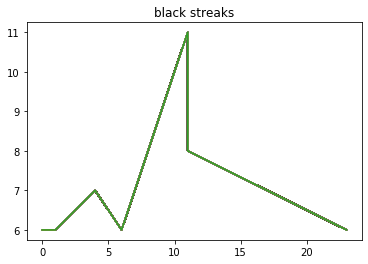

In [57]:
bvsr=0
plt.title("black streaks")
for seed in range(1900, 2233):
    data = pd.read_json(f'data/seed_{seed}.json')
    #print the head
    df = pd.json_normalize(data["rolls"])
    b,r,g = getTotals(df)
    if b > r : 
        bvsr+=1
    
    #print(f" seed {seed} -- black : {b} | red : {r} | green : {g} \n")
    #black_LS, red_LS = longest_streaks(df)
    #print(f" longest black streak : {black_LS} and red longest streak : {red_LS} \n")
    nb, bst, rst, bls, rls = get_nb_long_streaks(df)
    times= []
    for i in range(len(bst)):
        times.append(datetime.strptime(bst[i], "%Y-%m-%d %H:%M:%S").hour)
    #print(len(bls))
    #print("\n", len(times))
    plt.plot(times, bls)
    
#print(f"nbr of times blacks appear more often than red : {bvsr} <=> {(bvsr/27)}")


In [77]:
streak_chart_black = np.zeros(24)
streak_chart_red = np.zeros(24)
for i in range(2133, 2233):
    data = pd.read_json(f'data/seed_{i}.json')
    #print the head
    df = pd.json_normalize(data["rolls"])
    nb, bst, rst, bls, rls = get_nb_long_streaks(df)
    times= []
    for i in range(len(bst)):
        h = int(datetime.strptime(bst[i],  "%Y-%m-%d %H:%M:%S").hour)
        streak_chart_black [h] +=1
    for i in range(len(rst)):
        h = int(datetime.strptime(rst[i],  "%Y-%m-%d %H:%M:%S").hour)
        streak_chart_red [h] +=1

In [78]:
streak_chart_black

array([37., 30., 34., 30., 44., 33., 40., 21., 43., 32., 37., 40., 31.,
       36., 28., 33., 34., 30., 32., 36., 26., 41., 27., 28.])

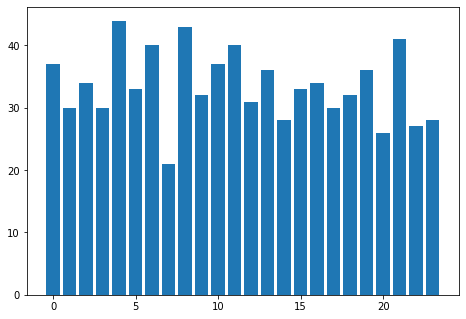

In [79]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
time = [x for x in range(0,24)] #heures
ax.bar(time,streak_chart_black)
plt.show()

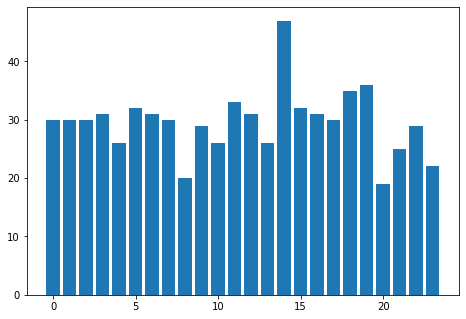

In [80]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
time = [x for x in range(0,24)] #heures
ax.bar(time,streak_chart_red)
plt.show()

In [38]:
training_set = df.iloc[:2000, 1:2].values
test_set = df.iloc[2000:, 1:2].values

In [39]:
X_train = []
y_train = []
#sc = MinMaxScaler(feature_range = (0, 1))
#training_set_scaled = sc.fit_transform(training_set)
for i in range(10, 2000):
    X_train.append(training_set[i-10:i, 0])
    y_train.append(training_set[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(740, 60, 1)

In [42]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 100)

Epoch 1/100
20/20 [==============================] - 3s 22ms/step - loss: 1.1654 - accuracy: 0.2732
Epoch 2/100
20/20 [==============================] - 0s 21ms/step - loss: 0.4029 - accuracy: 0.4768
Epoch 3/100
20/20 [==============================] - 0s 21ms/step - loss: 0.3972 - accuracy: 0.4568
Epoch 4/100
20/20 [==============================] - 0s 21ms/step - loss: 0.4140 - accuracy: 0.4522
Epoch 5/100
20/20 [==============================] - 0s 21ms/step - loss: 0.3879 - accuracy: 0.4580
Epoch 6/100
20/20 [==============================] - 0s 21ms/step - loss: 0.3813 - accuracy: 0.4714
Epoch 7/100
20/20 [==============================] - 0s 21ms/step - loss: 0.3880 - accuracy: 0.4580
Epoch 8/100
20/20 [==============================] - 0s 21ms/step - loss: 0.3685 - accuracy: 0.4712
Epoch 9/100
20/20 [==============================] - 0s 21ms/step - loss: 0.3629 - accuracy: 0.4736
Epoch 10/100
20/20 [==============================] - 0s 21ms/step - loss: 0.3667 - accuracy: 0.4746

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [25]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:2000, 1:2]
dataset_test = df.iloc[2000:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 100:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(100, 970):
    X_test.append(inputs[i-50:i, 0])
X_test = np.array(X_test)
show = X_test
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

(870, 50, 1)


In [27]:
predicted_coin = model.predict(X_test)
predicted_coin = sc.inverse_transform(predicted_coin)
predicted_coin

array([[1.4067295],
       [1.4069581],
       [1.4070897],
       [1.40716  ],
       [1.4071844],
       [1.4070837],
       [1.4068289],
       [1.4065913],
       [1.40657  ],
       [1.4068152],
       [1.4071486],
       [1.4073458],
       [1.4073095],
       [1.4070476],
       [1.406765 ],
       [1.4066871],
       [1.4066164],
       [1.4063523],
       [1.4060812],
       [1.4060456],
       [1.4063137],
       [1.4068182],
       [1.4073324],
       [1.4076287],
       [1.4076272],
       [1.4073567],
       [1.4070377],
       [1.406909 ],
       [1.407049 ],
       [1.407295 ],
       [1.4072928],
       [1.4070706],
       [1.406913 ],
       [1.4068503],
       [1.4067569],
       [1.4067001],
       [1.4066858],
       [1.4067438],
       [1.4069586],
       [1.4072177],
       [1.4073375],
       [1.4073718],
       [1.4073513],
       [1.4073377],
       [1.4073231],
       [1.4072084],
       [1.4070866],
       [1.4071183],
       [1.4073496],
       [1.4077342],
